In [12]:
import numpy as np
import matplotlib.pyplot as plt
import fnmatch
import cv2
from keras import layers
from keras import optimizers
from keras.models import Sequential
from keras.utils import to_categorical
from keras.preprocessing.image import ImageDataGenerator
import tensorflow
from tensorflow.keras.metrics import Recall
from glob import glob
from pandas import DataFrame
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import StratifiedKFold

### Data Wrangling and Preprocessing

Total Image Patches:  277524
Total Positive Patches:  78786
Total Negative Patches:  198738


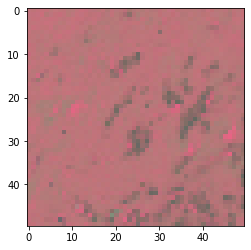

In [4]:
imageFiles = glob('/home/justin/.kaggle/idc/IDC_regular_ps50_idx5/**/*.png', 
              recursive = True)
images = np.array([cv2.cvtColor(cv2.resize(cv2.imread(file), (50,50)),  cv2.COLOR_BGR2Luv) for file in imageFiles])
imagesRBG = np.array([cv2.resize(cv2.imread(file), (50,50)) for file in imageFiles])
labels = np.array([0 if '0' == file[-5] else 1 for file in imageFiles])
# print(labels.shape)
# print(images.shape)
# d = {'Image': images, "Label": labels}
# data = DataFrame(data=d)
# print(data)
num_negative = np.count_nonzero(labels==0)
num_positive = np.count_nonzero(labels==1)
print("Total Image Patches: ", len(imageFiles))
print("Total Positive Patches: ", num_positive)
print("Total Negative Patches: ", num_negative)
plt.imshow(images[110])
#plt.imshow(imagesRBG[0])

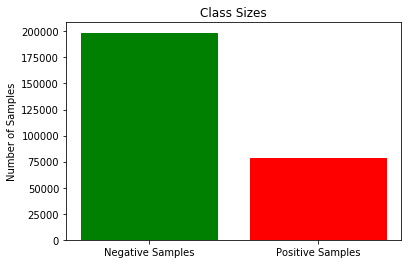

In [3]:
a = plt.bar((1,2),(num_negative, num_positive), align='center')
plt.xticks((1,2), ('Negative Samples', 'Positive Samples'))
plt.title('Class Sizes')
plt.ylabel("Number of Samples")
a[0].set_color('g')
a[1].set_color('r')
plt.show()

In [5]:
randomIdx = np.arange(len(imageFiles))
np.random.shuffle(randomIdx)

In [ ]:
# a = plt.bar((1,2),(num_negative, num_positive), align='center')
# plt.xticks((1,2), ('Negative Samples', 'Positive Samples'))
# plt.title('Class Sizes')
# plt.ylabel("Number of Samples")
# a[0].set_color('g')
# a[1].set_color('r')
# plt.show()
plt.imshow(images[110])


In [ ]:
plt.imshow(imagesRBG[110])

In [6]:
def testTrainSplit(images, labels, split = .8):
    n = len(images)
    div = int(split * n)
    xtrain, xtest = images[:div], images[div:]
    ytrain, ytest = labels[:div], labels[div:]
    return xtrain, ytrain, xtest, ytest

xtrain, ytrain, xtest, ytest = testTrainSplit( images, labels)
# # print(xtrain.shape)
# # print(xtest.shape)
# # print(ytrain.shape)
# # print(ytest.shape)

In [53]:
per = int(len(xtrain) * .8)
xtrain, xval = xtrain[:per], xtrain[per:]
ytrain, yval = ytrain[:per], ytrain[per:]

In [ ]:
# training_gen = ImageDataGenerator(featurewise_center=True,
#     featurewise_std_normalization=True,
#     rotation_range=180,
#     horizontal_flip=True,vertical_flip = True)
# test_gen = ImageDataGenerator(rescale=1./100)


# Base Model

In [7]:
kernel_size = 3

model = Sequential()

# CONV => RELU => POOL
model.add(layers.SeparableConv2D(32, kernel_size, padding="same", input_shape=(50,50,3)))
model.add(layers.LeakyReLU(alpha=0.3))
#model.add(layers.BatchNormalization(axis=1))
model.add(layers.MaxPooling2D(pool_size=(2, 2)))
model.add(layers.Dropout(0.25))

# (CONV => RELU => POOL) * 2
model.add(layers.SeparableConv2D(64, kernel_size, padding="same"))
model.add(layers.LeakyReLU(alpha=0.3))
#model.add(Layers.BatchNormalization(axis=1))
model.add(layers.SeparableConv2D(64, kernel_size, padding="same"))
model.add(layers.LeakyReLU(alpha=0.3))
#model.add(BatchNormalization(axis=1))
model.add(layers.SeparableConv2D(64, kernel_size, padding="same"))
model.add(layers.LeakyReLU(alpha=0.3))
model.add(layers.MaxPooling2D(pool_size=(2, 2)))
model.add(layers.Dropout(0.25))

# # (CONV => RELU => POOL) * 3
model.add(layers.SeparableConv2D(128, kernel_size, padding="same"))
model.add(layers.LeakyReLU(alpha=0.3))
#model.add(BatchNormalization(axis=1))
model.add(layers.SeparableConv2D(128, kernel_size, padding="same"))
model.add(layers.LeakyReLU(alpha=0.3))
#model.add(BatchNormalization(axis=1))
model.add(layers.SeparableConv2D(128, kernel_size, padding="same"))
model.add(layers.LeakyReLU(alpha=0.3))
#model.add(BatchNormalization(axis=1))
model.add(layers.MaxPooling2D(pool_size=(2, 2)))
model.add(layers.Dropout(0.25))

# model.add(layers.SeparableConv2D(256, kernel_size, padding="same"))
# model.add(layers.LeakyReLU(alpha=0.3))
# model.add(layers.MaxPooling2D(pool_size=(2,2)))

model.add(layers.Flatten())
model.add(layers.Dense(256))
model.add(layers.LeakyReLU(alpha=0.3))
model.add(layers.Dropout(.5))
model.add(layers.Dense(1, activation="sigmoid"))

model.compile(loss="binary_crossentropy", 
              optimizer='Adam',
              metrics=[Recall(), 'accuracy'])



Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


In [55]:
kernel_size = 3
x_images, y_images= xtrain, ytrain
kfold = StratifiedKFold(n_splits=2, shuffle=True)

data = {}
i=0
acc, val_acc, loss, val_loss = [], [], [], []
for trainIndex, testIndex in kfold.split(x_images, y_images):

    model = Sequential()

    # CONV => LEAKYRELU => POOL
    model.add(layers.SeparableConv2D(32, kernel_size, padding="same", input_shape=(50,50,3)))
    model.add(layers.LeakyReLU(alpha=0.3))
    model.add(layers.MaxPooling2D(pool_size=(2, 2)))

    # (CONV => LEAKYRELU => POOL) * 3
    model.add(layers.SeparableConv2D(64, kernel_size, padding="same"))
    model.add(layers.LeakyReLU(alpha=0.3))
    model.add(layers.SeparableConv2D(64, kernel_size, padding="same"))
    model.add(layers.LeakyReLU(alpha=0.3))
    model.add(layers.SeparableConv2D(64, kernel_size, padding="same"))
    model.add(layers.LeakyReLU(alpha=0.3))
    model.add(layers.MaxPooling2D(pool_size=(2, 2)))
    model.add(layers.Dropout(0.25))

    # (CONV => LEAKYRELU => POOL) * 3
    model.add(layers.SeparableConv2D(128, kernel_size, padding="same"))
    model.add(layers.LeakyReLU(alpha=0.3))
    model.add(layers.SeparableConv2D(128, kernel_size, padding="same"))
    model.add(layers.LeakyReLU(alpha=0.3))
    model.add(layers.SeparableConv2D(128, kernel_size, padding="same"))
    model.add(layers.LeakyReLU(alpha=0.3))
    model.add(layers.MaxPooling2D(pool_size=(2, 2)))
    model.add(layers.Dropout(0.25))

    # model.add(layers.SeparableConv2D(256, kernel_size, padding="same"))
    # model.add(layers.LeakyReLU(alpha=0.3))
    # model.add(layers.MaxPooling2D(pool_size=(2,2)))

    model.add(layers.Flatten())
    model.add(layers.Dense(256))
    model.add(layers.LeakyReLU(alpha=0.3))
    model.add(layers.Dropout(.5))
    model.add(layers.Dense(1, activation="sigmoid"))
    model.compile(loss="binary_crossentropy", 
                optimizer='Adam',
                metrics=[Recall(), 'accuracy'])
    history = model.fit(x_images[trainIndex], y_images[trainIndex], epochs=30, 
                        batch_size=32, validation_data=(x_images[testIndex], y_images[testIndex]))
    acc.append(history.history['accuracy'])
    val_acc.append(history.history['val_accuracy'])
    loss.append(history.history['loss'])
    val_loss.append(history.history['val_loss'])

Train on 88807 samples, validate on 88808 samples
Epoch 1/30
88807/88807 [==============================] - 386s 4ms/step - loss: 0.4635 - recall_7: 0.4064 - accuracy: 0.7863 - val_loss: 0.4258 - val_recall_7: 0.5637 - val_accuracy: 0.8051
Epoch 2/30
88807/88807 [==============================] - 398s 4ms/step - loss: 0.3959 - recall_7: 0.6171 - accuracy: 0.8251 - val_loss: 0.3740 - val_recall_7: 0.6289 - val_accuracy: 0.8368
Epoch 3/30
88807/88807 [==============================] - 386s 4ms/step - loss: 0.3784 - recall_7: 0.6405 - accuracy: 0.8333 - val_loss: 0.3499 - val_recall_7: 0.6472 - val_accuracy: 0.8450
Epoch 4/30
88807/88807 [==============================] - 361s 4ms/step - loss: 0.3641 - recall_7: 0.6547 - accuracy: 0.8404 - val_loss: 0.3394 - val_recall_7: 0.6601 - val_accuracy: 0.8528
Epoch 5/30
88807/88807 [==============================] - 374s 4ms/step - loss: 0.3523 - recall_7: 0.6663 - accuracy: 0.8452 - val_loss: 0.3339 - val_recall_7: 0.6713 - val_accuracy: 0.8535


In [62]:
acc1 = np.array(acc).mean(axis=0)
val_acc1 = np.array(val_acc).mean(axis=0)
loss1 = np.array(loss).mean(axis=0)
val_loss1 = np.array(val_loss).mean(axis=0)

print(acc1.shape)
print(val_acc1.shape)
print(loss1.shape)
print(val_loss1.shape)

(30,)
(30,)
(30,)
(30,)


dict_keys(['val_loss', 'val_recall_8', 'val_accuracy', 'loss', 'recall_8', 'accuracy'])
[0.8145754337310791, 0.8323555588722229, 0.8457328677177429, 0.8452149033546448, 0.8491785526275635, 0.8495276570320129, 0.8563627004623413, 0.8491560220718384, 0.858040452003479, 0.8577139377593994, 0.8534011840820312, 0.8487619161605835, 0.8584120869636536, 0.8558334112167358, 0.8493249416351318, 0.866001546382904, 0.8641210794448853, 0.8587160706520081, 0.8645827174186707, 0.8617676496505737, 0.8606641292572021, 0.8513855934143066, 0.8646953701972961, 0.8614523410797119, 0.8649881482124329, 0.8539191484451294, 0.8614974021911621, 0.8422309160232544, 0.8585359454154968, 0.867746889591217]


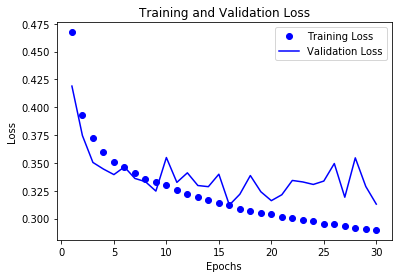

In [86]:
history_dict = history.history
print(history_dict.keys())
print(history_dict['val_accuracy'])

lossVals = loss1#history_dict['loss']
validateLossVals = val_loss1#history_dict['val_loss']
epochs = range(1, len(lossVals)+1)
plt.plot(epochs, lossVals, 'bo', label='Training Loss')
plt.plot(epochs, validateLossVals, 'b', label="Validation Loss")
plt.title("Training and Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

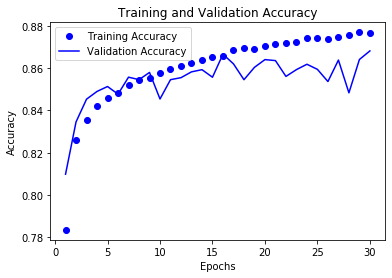

In [87]:
acc = acc1#history_dict['accuracy']
valAcc = val_acc1#history_dict['val_accuracy']
epochs = range(1, len(acc)+1)
plt.plot(epochs, acc, 'bo', label='Training Accuracy')
plt.plot(epochs, valAcc, 'b', label="Validation Accuracy")
plt.title("Training and Validation Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

In [ ]:
print(data)
pos, neg = [], []
for d in data:
    d = data[d]
    pos.append(d[0])
    neg.append(d[1])

ind = np.arange(5)
width = .4
plt.bar(ind, pos, width, label="Positive", color='r')
plt.bar(ind+width, neg, width, label="Negative", color="g")
plt.ylabel('Number of Samples')
plt.xticks(ind+width/2, ('Fold 1','Fold 2','Fold 3', 'Fold 4', 'Fold 5'))
plt.legend(loc='best')

In [ ]:
    data['fold'] = i
    data['pos_samples'] = np.count_nonzero(y_images[trainIndex]==1)
    data['neg_samples'] = np.count_nonzero(y_images[trainIndex]==0)
    data['loss'] = history.history['loss']
    data['val_loss'] = history.history['val_loss']
    data['val_accuracy'] = history.history['val_accuracy']
    data['accuracy'] = history.history['val_accuracy']
    

In [8]:
history = model.fit(xtrain, ytrain, epochs=16, batch_size=32)
#history = model.fit_generator(training_gen.flow(xtrain, ytrain, batch_size=32), epochs=20, validation_data=(xval, yval))


Epoch 1/16
222019/222019 [==============================] - 650s 3ms/step - loss: 0.4253 - recall: 0.4233 - accuracy: 0.8097
Epoch 2/16
222019/222019 [==============================] - 706s 3ms/step - loss: 0.3762 - recall: 0.5705 - accuracy: 0.8350
Epoch 3/16
222019/222019 [==============================] - 724s 3ms/step - loss: 0.3598 - recall: 0.6081 - accuracy: 0.8429
Epoch 4/16
222019/222019 [==============================] - 664s 3ms/step - loss: 0.3479 - recall: 0.6298 - accuracy: 0.8482
Epoch 5/16
222019/222019 [==============================] - 664s 3ms/step - loss: 0.3396 - recall: 0.6443 - accuracy: 0.8529
Epoch 6/16
222019/222019 [==============================] - 661s 3ms/step - loss: 0.3309 - recall: 0.6555 - accuracy: 0.8576
Epoch 7/16
222019/222019 [==============================] - 643s 3ms/step - loss: 0.3251 - recall: 0.6639 - accuracy: 0.8610
Epoch 8/16
222019/222019 [==============================] - 692s 3ms/step - loss: 0.3206 - recall: 0.6714 - accuracy: 0.8629

In [ ]:
history_dict = history.history
print(history_dict.keys())
print(history_dict['val_accuracy'])

lossVals = history_dict['loss']
validateLossVals = history_dict['val_loss']
epochs = range(1, len(lossVals)+1)
plt.plot(epochs, lossVals, 'bo', label='Training Loss')
plt.plot(epochs, validateLossVals, 'b', label="Validation Loss")
plt.title("Training and Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

In [ ]:
recall = history_dict['recall_6']
valRecall = history_dict['val_recall_6']
epochs = range(1, len(recall)+1)
plt.plot(epochs, recall, 'bo', label='Training Recall')
plt.plot(epochs, valRecall, 'b', label="Validation Recall")
plt.title("Training and Validation Recall")
plt.xlabel("Epochs")
plt.ylabel("Recall")
plt.legend()
plt.show()

In [ ]:
acc = history_dict['accuracy']
valAcc = history_dict['val_accuracy']
epochs = range(1, len(acc)+1)
plt.plot(epochs, acc, 'bo', label='Training Accuracy')
plt.plot(epochs, valAcc, 'b', label="Validation Accuracy")
plt.title("Training and Validation Recall")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

In [9]:
model.evaluate(xtest, ytest)

55505/55505 [==============================] - 45s 815us/step


[0.29752462046493894, 0.7029577493667603, 0.8751463890075684]

In [27]:
model.save('name.h5')

In [15]:

cpred = model.predict(xtest, use_multiprocessing=True)
cpred = np.around(cpred, decimals=0)



In [25]:
classes = ["IDC not present", "IDC present"]
columns = ["IDC not present", "IDC present"]

con_mat = np.array(tensorflow.math.confusion_matrix(labels=ytest, predictions=cpred))
con_mat_norm = np.around(con_mat.astype('float') / con_mat.sum(axis=1)[:, np.newaxis], decimals=2)

con_mat_df = DataFrame(con_mat_norm,
                     index = classes, 
                     columns = classes)

figure = plt.figure(figsize=(8, 8))
seaborn.heatmap(con_mat_df, annot=True,cmap=plt.cm.Blues)
plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

ValueError: setting an array element with a sequence.

In [ ]:
pred_labels = model.predict(xtest, use_multiprocessing=True)
pred_labels = np.argmax(pred_labels, axis=1)


In [ ]:
print(history_dict['val_accuracy'])
print(history_dict['val_recall_6'])
print(history_dict['val_loss'])